In [1]:
# importing libraries for the API connection

import tweepy
from tweepy.auth import OAuthHandler
import pandas as pd

In [2]:
# generating a dict with the keys for the API connection

secrets_dict={}
secrets_file = open('tweepy-keys.txt')
for line in secrets_file:
  (key,value) = line.split(':')
  secrets_dict[key] = value[:-1]

In [3]:
# creating the API cursor

auth = tweepy.OAuthHandler(secrets_dict['API Key'], secrets_dict['API secret'])
auth.set_access_token(secrets_dict['Access token'], secrets_dict['Access secret'])
api = tweepy.API(auth)

In [4]:
def scrape(words, date_since, numtweet):

# Creating DataFrame using pandas
  db = pd.DataFrame(columns=['username', 'description', 'location', 'following',
              'followers', 'totaltweets', 'retweetcount', 'text', 'hashtags'])

# We are using .Cursor() to search through twitter for the required tweets.
# The number of tweets can be restricted using .items(number of tweets)
  tweets = tweepy.Cursor(api.search, q=words, lang="en",
            since=date_since, tweet_mode='extended').items(numtweet)

# .Cursor() returns an iterable object. Each item in
# the iterator has various attributes that you can access to
# get information about each tweet
  list_tweets = [tweet for tweet in tweets]

# Counter to maintain Tweet Count
  i = 1

# we will iterate over each tweet in the list for extracting information about each tweet
  for tweet in list_tweets:
    username = tweet.user.screen_name
    description = tweet.user.description
    location = tweet.user.location
    following = tweet.user.friends_count
    followers = tweet.user.followers_count
    totaltweets = tweet.user.statuses_count
    retweetcount = tweet.retweet_count
    hashtags = tweet.entities['hashtags']
  
# Retweets can be distinguished by a retweeted_status attribute,
# in case it is an invalid reference, except block will be executed
    try:
      text = tweet.retweeted_status.full_text
    except AttributeError:
      text = tweet.full_text
    hashtext = list()
    for j in range(0, len(hashtags)):
      hashtext.append(hashtags[j]['text'])

    # Here we are appending all the extracted information in the DataFrame
    ith_tweet = [username, description, location, following,
          followers, totaltweets, retweetcount, text, hashtext]
    db.loc[len(db)] = ith_tweet

  

# we will save our database as a CSV file.
  return db

In [5]:
# define forloop that scrapes the necessary tweets and concatenates them

import time # twitter limitates the amount of scrapping you can do, so we need to do timesleep
from datetime import date

# politic is the list of politicians to scrape for
# Enter Date since The Tweets are required in yyyy-mm-dd
# The minutes its the time it will spend between each iteration of the scrape
# numtweet is the number of tweets for each hashtag
# file is the older file that i might have and i want to concatenate with

# WARNING: Remove the default politicians before deploying

def scrapping_engine(date_,politic=['#JoeBiden','#BernieSanders','#MikePence','#TedCruz'], minutes=15, numtweet=500, file=0):

    # we need to create a dataframe to deposit the tweets that we scrape

    columns = ['target','Unnamed: 0', 'username', 'description', 'location', 'following',
           'followers', 'totaltweets', 'retweetcount', 'text', 'hashtags'] # this are the columns that for the dataframe

    politic_df = pd.DataFrame(dict(), columns=columns) # creation of the dataframe

    # this is the loop for the scrapping of every politician

    for element in politic:
        subdata = scrape(element, date_, numtweet)
        subdata['target'] = element
        politic_df = politic_df.append(subdata)
        time.sleep(60 * minutes) # need to take it easy!
        
    csv = file
    
    politic_df = appending(politic_df, csv)
    
    spams_count = dict(politic_df['text'].value_counts())

    spams = []

    for x,y in spams_count.items():
        if y > 1:
            spams.append(x)

    counter = 0

    politic_df = politic_df.reset_index()

    for element in politic_df['text']:
        if element in spams:
            politic_df.drop(index=counter, inplace=True)
        counter += 1
    
    new_date = 'scraped_from_' + date_ + '_to_' + str(date.today())
    
    if csv != 0:
        politic_df.to_csv(new_date + '.csv', index_label=False)
        return politic_df
    else:
        politic_df.to_csv(new_date + '.csv', index_label=False)
        return politic_df


In [6]:
# define a function that adds the newly scraped file to the rest

def appending(db, file):
    older = pd.read_csv(file)
    return db.append(older) # returns the new database appended

In [7]:
def politicians_input():
    print('Enter the politicians names (separated by comma, E.g: ´Joe Biden, Bernie Sanders´): ')
    string_ = input()
    string = string_.replace(' ','')
    list_strings = string.split(',')

    return [('#' + x) for x in list_strings]

In [ ]:
to_scrape = politicians_input()

# do a function for date input

politic_df = scrapping_engine('2021-07-22', to_scrape, 0.1, 10, 'data.csv')

In [8]:
politic_df = pd.read_csv('scraped_from_2021-07-22_to_2021-07-23.csv')

In [9]:
politic_df.shape

(1049, 13)

In [10]:
politic_df.head()

,index,target,Unnamed: 0,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,Unnamed: 0.1
0,0,#JoeBiden,NaN,Michell81478626,"I live in Minnesota, I love my cat, dog and bi...","Minnesota, USA",69,12,60,2,#Congress #chuckSchumer #nancyPelosi #democrat...,"['Congress', 'chuckSchumer', 'nancyPelosi', 'd...",NaN
2,2,#JoeBiden,NaN,DerekOsheaShow,Derek O'Shea Show Politically Homeless Daily C...,Everywhere you want to be,3435,781,5095,0,Who is Defunding Police | Conspiracy Theories ...,"['Covid19News', 'JoeBiden', 'BreakingNews', 'p...",NaN
3,3,#JoeBiden,NaN,Tim20026046,"White-haired, upper fifties, libertarian dad, ...",NaN,485,17,4239,98,"#JoeBiden Tells The World Another Whopper ""You...",['JoeBiden'],NaN
4,4,#JoeBiden,NaN,lilgoddamn_III,#bitcoin\n§LilGoddamn,The Moon 🌕,900,297,28972,57,Democrats Future Agenda...\n\n#NacyPelosi :\nL...,"['NacyPelosi', 'JoeBiden']",NaN
5,5,#JoeBiden,NaN,LisaMaret,"Founder, Tea Party WDC ""Return 2 commerce, cha...",Alexandria Va,1446,1735,69535,0,"@taxreformer Big surprise, the IRS doesn't aud...","['LarcenousClass', 'Democrats', 'JoeBiden', 'P...",NaN


In [11]:
# now we need to clean the tweets
# importing the necessaire packages


import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# the main cleaning step

def clean_up(s):
    element1 = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', s) # remove links
    element2 = re.sub('[^a-zA-Z0-9]', ' ', element1) # remove non character symbols
    element3 = re.sub('amp', '', element2) # twitter has &amp as a special character
    return (re.sub('\d+',' ',element3)).lower() # remove any digits and lowercase everything

In [13]:
# tokenize the text

def tokenize(s):
    return word_tokenize(s)

In [14]:
# categorize function to help the next function that is lemmatize

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper() # gets first letter of POS categorization
    tag_dict = {"J": wordnet.ADJ, 
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # get returns second argument if first key does not exist

In [15]:
# lemmatize to reduce the word to it most radical form

def lemmatize(l):
  
    lem = WordNetLemmatizer()
    lemmatized = [lem.lemmatize(w,get_wordnet_pos(w)) for w in l]
    
    return lemmatized

In [16]:
# remove the stop words

def remove_stopwords(l):
    
    filtered_sentence = []
    
    for w in l:
        if len(w) > 1:
            if w not in stopwords.words('english'):
                filtered_sentence.append(w)
    
    return filtered_sentence

In [17]:
# function that combines all of the cleaning functions and does everything

def cleaning_engine(df,column='text'):
    df['text_processed'] = df[column].apply(clean_up)
    df['text_processed'] = df['text_processed'].apply(tokenize)
    df['text_processed'] = df['text_processed'].apply(lemmatize)
    return df['text_processed'].apply(remove_stopwords)
    

In [18]:
politic_df['text_processed'] = cleaning_engine(politic_df)

In [19]:
politic_df['text_processed'].head()

0    [congress, chuckschumer, nancypelosi, democrat...
2    [defunding, police, conspiracy, theory, town, ...
3    [joebiden, tell, world, another, whopper, get,...
4    [democrat, future, nacypelosi, latin, future, ...
5    [taxreformer, big, surprise, irs, audit, larce...
Name: text_processed, dtype: object

In [20]:
politic_df['text_preprocessed'] = politic_df['text'].apply(clean_up)

In [24]:
politic_df.head()

,index,target,Unnamed: 0,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,Unnamed: 0.1,text_processed,text_preprocessed
0,0,#JoeBiden,NaN,Michell81478626,"I live in Minnesota, I love my cat, dog and bi...","Minnesota, USA",69,12,60,2,#Congress #chuckSchumer #nancyPelosi #democrat...,"['Congress', 'chuckSchumer', 'nancyPelosi', 'd...",NaN,"[congress, chuckschumer, nancypelosi, democrat...",congress chuckschumer nancypelosi democrat...
2,2,#JoeBiden,NaN,DerekOsheaShow,Derek O'Shea Show Politically Homeless Daily C...,Everywhere you want to be,3435,781,5095,0,Who is Defunding Police | Conspiracy Theories ...,"['Covid19News', 'JoeBiden', 'BreakingNews', 'p...",NaN,"[defunding, police, conspiracy, theory, town, ...",who is defunding police conspiracy theories ...
3,3,#JoeBiden,NaN,Tim20026046,"White-haired, upper fifties, libertarian dad, ...",NaN,485,17,4239,98,"#JoeBiden Tells The World Another Whopper ""You...",['JoeBiden'],NaN,"[joebiden, tell, world, another, whopper, get,...",joebiden tells the world another whopper you...
4,4,#JoeBiden,NaN,lilgoddamn_III,#bitcoin\n§LilGoddamn,The Moon 🌕,900,297,28972,57,Democrats Future Agenda...\n\n#NacyPelosi :\nL...,"['NacyPelosi', 'JoeBiden']",NaN,"[democrat, future, nacypelosi, latin, future, ...",democrats future a nacypelosi latin s are ...
5,5,#JoeBiden,NaN,LisaMaret,"Founder, Tea Party WDC ""Return 2 commerce, cha...",Alexandria Va,1446,1735,69535,0,"@taxreformer Big surprise, the IRS doesn't aud...","['LarcenousClass', 'Democrats', 'JoeBiden', 'P...",NaN,"[taxreformer, big, surprise, irs, audit, larce...",taxreformer big surprise the irs doesn t aud...


In [28]:
test = politic_df['text_preprocessed'][0].strip()

In [26]:
features = politic_df[['target','text_processed','text_preprocessed']].reset_index()
features.head()

,index,target,text_processed,text_preprocessed
0,0,#JoeBiden,"[congress, chuckschumer, nancypelosi, democrat...",congress chuckschumer nancypelosi democrat...
1,2,#JoeBiden,"[defunding, police, conspiracy, theory, town, ...",who is defunding police conspiracy theories ...
2,3,#JoeBiden,"[joebiden, tell, world, another, whopper, get,...",joebiden tells the world another whopper you...
3,4,#JoeBiden,"[democrat, future, nacypelosi, latin, future, ...",democrats future a nacypelosi latin s are ...
4,5,#JoeBiden,"[taxreformer, big, surprise, irs, audit, larce...",taxreformer big surprise the irs doesn t aud...


In [139]:
features['text_preprocessed'][0]

' congress  chuckschumer  nancypelosi  democrats  joebiden  kamalaharris  purplepower the time for action in now  no more vacations  no luncheons it s time to fix this country and get them back on their feet  back to work and out of the bread lines multiple stimulus checks now '

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def is_positive(tweet):
    if sia.polarity_scores(tweet)["compound"] > 0:
        return 1
    return 0

features['sentiment'] = features['text_preprocessed'].apply(is_positive)

In [113]:
features.head()

,index,target,text_processed,text_preprocessed,sentiment
0,0,#JoeBiden,"[congress, chuckschumer, nancypelosi, democrat...",congress chuckschumer nancypelosi democrat...,0
1,2,#JoeBiden,"[defunding, police, conspiracy, theory, town, ...",who is defunding police conspiracy theories ...,0
2,3,#JoeBiden,"[joebiden, tell, world, another, whopper, get,...",joebiden tells the world another whopper you...,0
3,4,#JoeBiden,"[democrat, future, nacypelosi, latin, future, ...",democrats future a nacypelosi latin s are ...,1
4,5,#JoeBiden,"[taxreformer, big, surprise, irs, audit, larce...",taxreformer big surprise the irs doesn t aud...,1


In [28]:
def intensity(tweet):
    return (abs(sia.polarity_scores(tweet)["compound"])+1)**2

features['intensity'] = features['text_preprocessed'].apply(intensity)


In [29]:
features.head()

,index,target,text_processed,text_preprocessed,sentiment,intensity
0,0,#JoeBiden,"[congress, chuckschumer, nancypelosi, democrat...",congress chuckschumer nancypelosi democrat...,0,2.330813
1,2,#JoeBiden,"[defunding, police, conspiracy, theory, town, ...",who is defunding police conspiracy theories ...,0,1.000000
2,3,#JoeBiden,"[joebiden, tell, world, another, whopper, get,...",joebiden tells the world another whopper you...,0,2.378689
3,4,#JoeBiden,"[democrat, future, nacypelosi, latin, future, ...",democrats future a nacypelosi latin s are ...,1,1.503812
4,5,#JoeBiden,"[taxreformer, big, surprise, irs, audit, larce...",taxreformer big surprise the irs doesn t aud...,1,1.621038


In [ ]:
all_words = ' '.join([text for text in combi['tidy_tweet']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

In [ ]:
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

In [85]:
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence


def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(features['text_processed']) # label all the tweets


model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=50, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=2, # Ignores all words with total frequency lower than 2.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(features['text_preprocessed']), epochs=5)

C:\Users\DELL\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
<ipython-input-85-7f50e655c8c2>:9: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))
100%|██████████| 1049/1049 [00:00<?, ?it/s]


In [87]:
docvec_arrays = np.zeros((len(features['text_processed']), 50)) 
for i in range(len(features)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,50))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(1049, 50)

In [93]:
docvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.106436,0.049223,-0.089414,0.042136,0.059036,0.019947,-0.056285,-0.021309,0.031356,0.078296,...,-0.110595,-0.035767,0.057435,0.123489,0.027829,-0.108267,-0.035640,0.018942,-0.114740,-0.010601
1,0.112734,0.056405,-0.093028,-0.000482,0.090805,0.068443,-0.081364,-0.060023,0.072197,0.086086,...,-0.133141,0.003248,0.009084,0.155137,0.034524,-0.095360,-0.045208,-0.003847,-0.091460,-0.047509
2,0.117241,0.033822,-0.109248,0.028589,0.095310,0.041983,-0.039210,-0.036165,0.062404,0.068089,...,-0.154306,-0.014996,0.034466,0.153602,0.022266,-0.098413,-0.044182,-0.000095,-0.101196,-0.059079
3,0.145545,0.030311,-0.134819,0.040069,0.124214,0.016837,-0.062625,-0.050021,0.093495,0.111671,...,-0.205460,-0.011153,0.080232,0.185157,-0.015471,-0.119387,-0.058265,0.025704,-0.142754,-0.081537
4,0.135904,0.027621,-0.111085,0.026658,0.100554,0.043277,-0.048041,-0.039815,0.075895,0.078011,...,-0.170455,-0.009540,0.058809,0.180327,-0.012761,-0.096216,-0.035350,0.001976,-0.110751,-0.072984


In [98]:
target_features_df = pd.concat([features, docvec_df], axis=1)

In [105]:
target_features_df.head()

,index,target,text_processed,text_preprocessed,sentiment,intensity,ClusterLabel,ClusterLabel_doc,0,1,...,40,41,42,43,44,45,46,47,48,49
0,0,#JoeBiden,"[congress, chuckschumer, nancypelosi, democrat...",congress chuckschumer nancypelosi democrat...,0,2.330813,43,17,0.106436,0.049223,...,-0.110595,-0.035767,0.057435,0.123489,0.027829,-0.108267,-0.035640,0.018942,-0.114740,-0.010601
1,2,#JoeBiden,"[defunding, police, conspiracy, theory, town, ...",who is defunding police conspiracy theories ...,0,1.000000,8,0,0.112734,0.056405,...,-0.133141,0.003248,0.009084,0.155137,0.034524,-0.095360,-0.045208,-0.003847,-0.091460,-0.047509
2,3,#JoeBiden,"[joebiden, tell, world, another, whopper, get,...",joebiden tells the world another whopper you...,0,2.378689,50,0,0.117241,0.033822,...,-0.154306,-0.014996,0.034466,0.153602,0.022266,-0.098413,-0.044182,-0.000095,-0.101196,-0.059079
3,4,#JoeBiden,"[democrat, future, nacypelosi, latin, future, ...",democrats future a nacypelosi latin s are ...,1,1.503812,50,22,0.145545,0.030311,...,-0.205460,-0.011153,0.080232,0.185157,-0.015471,-0.119387,-0.058265,0.025704,-0.142754,-0.081537
4,5,#JoeBiden,"[taxreformer, big, surprise, irs, audit, larce...",taxreformer big surprise the irs doesn t aud...,1,1.621038,38,22,0.135904,0.027621,...,-0.170455,-0.009540,0.058809,0.180327,-0.012761,-0.096216,-0.035350,0.001976,-0.110751,-0.072984


In [106]:
target_features_df.drop(columns=['text_processed','text_preprocessed'], inplace=True)

In [107]:
target_features_df.drop(columns=['ClusterLabel','ClusterLabel_doc'], inplace=True)

In [108]:
target_features_df.head()

,index,target,sentiment,intensity,0,1,2,3,4,5,...,40,41,42,43,44,45,46,47,48,49
0,0,#JoeBiden,0,2.330813,0.106436,0.049223,-0.089414,0.042136,0.059036,0.019947,...,-0.110595,-0.035767,0.057435,0.123489,0.027829,-0.108267,-0.035640,0.018942,-0.114740,-0.010601
1,2,#JoeBiden,0,1.000000,0.112734,0.056405,-0.093028,-0.000482,0.090805,0.068443,...,-0.133141,0.003248,0.009084,0.155137,0.034524,-0.095360,-0.045208,-0.003847,-0.091460,-0.047509
2,3,#JoeBiden,0,2.378689,0.117241,0.033822,-0.109248,0.028589,0.095310,0.041983,...,-0.154306,-0.014996,0.034466,0.153602,0.022266,-0.098413,-0.044182,-0.000095,-0.101196,-0.059079
3,4,#JoeBiden,1,1.503812,0.145545,0.030311,-0.134819,0.040069,0.124214,0.016837,...,-0.205460,-0.011153,0.080232,0.185157,-0.015471,-0.119387,-0.058265,0.025704,-0.142754,-0.081537
4,5,#JoeBiden,1,1.621038,0.135904,0.027621,-0.111085,0.026658,0.100554,0.043277,...,-0.170455,-0.009540,0.058809,0.180327,-0.012761,-0.096216,-0.035350,0.001976,-0.110751,-0.072984


In [117]:
def labelization(row):
    if row == '#JoeBiden':
        return 0
    elif row == '#BernieSanders':
        return 1
    elif row == '#TedCruz':
        return 2
    elif row == '#MikePence':
        return 3

In [211]:
from sklearn.decomposition import PCA

X = target_features_df.drop(columns=['index','target'])
y= target_features_df['target'].apply(labelization)

# create the PCA object
# the number of components chosen will be the new number of features!
pca = PCA(n_components = 5)
# fit the PCA model to breast cancer data
pca.fit(X)
# it's like we have three new axis (those defined by the PCA principal components)
X_pca = pca.transform(X)

In [212]:
from sklearn.model_selection import cross_val_score

cross_val_score(pca, X_pca, cv=5)

array([-0.82064884, -2.22505948, -1.93219735, -1.72296812, -3.90297591])

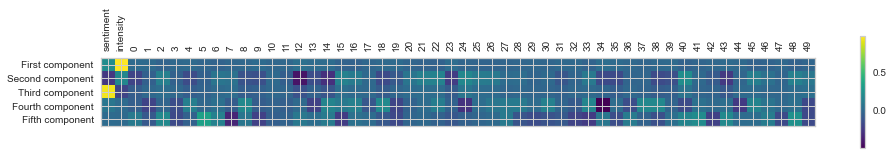

In [216]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1, 2,3,4], ["First component", "Second component","Third component","Fourth component","Fifth component"])
plt.colorbar()
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.show()

In [206]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# import numpy as np

# r2 = r2_score(X, X_pca)
# rmse = sqrt(mean_squared_error(X, X_pca))

# # RMSE normalised by mean:
# nrmse = rmse/sqrt(np.mean(X**2))

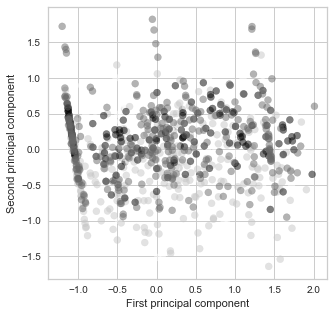

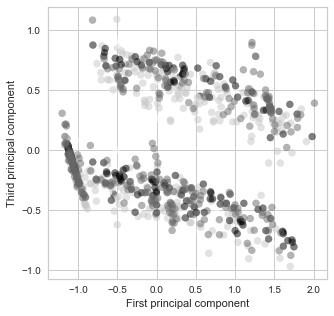

In [208]:
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0],X_pca[:, 1], c=y,alpha=0.5)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()
plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0],X_pca[:, 2], c=y,alpha=0.5)
plt.xlabel("First principal component")
plt.ylabel("Third principal component")
plt.show()

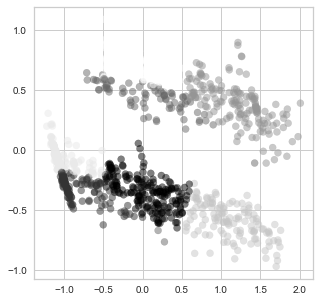

In [209]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score


kmeans = cluster.KMeans(n_clusters=7)
kmeans.fit(X_pca)
pred = kmeans.predict(X_pca)

plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 2], c=pred,alpha=0.5)
plt.show()

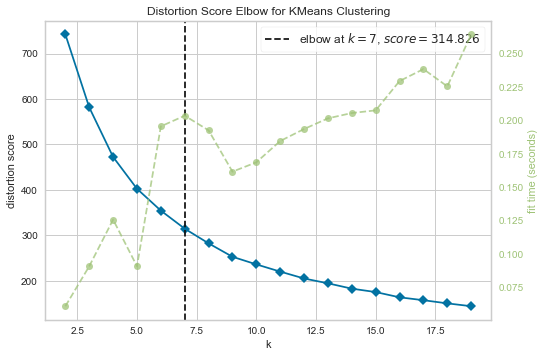

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [170]:
from yellowbrick.cluster import KElbowVisualizer

model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(X)
visualizer.poof()

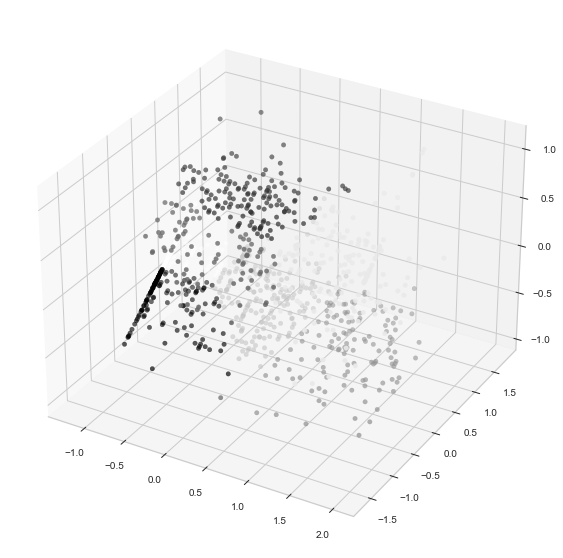

In [201]:

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=pred)
plt.show()

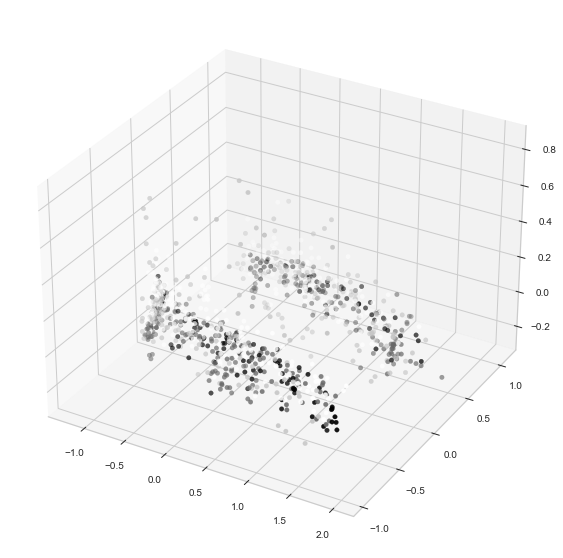

In [213]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 2], X_pca[:, 4], c=y)
plt.show()

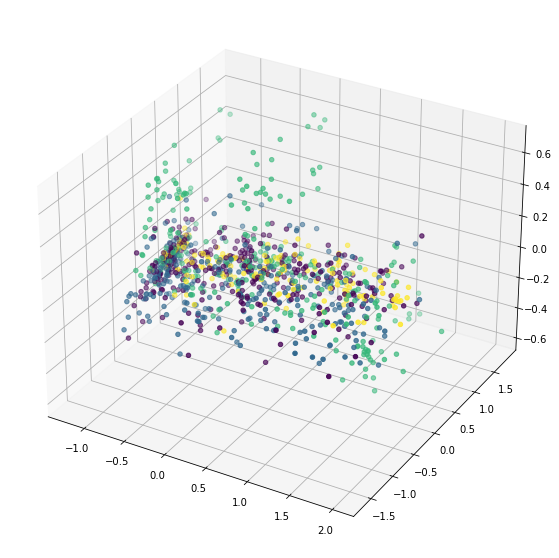

In [151]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 3], c=y)
plt.show()

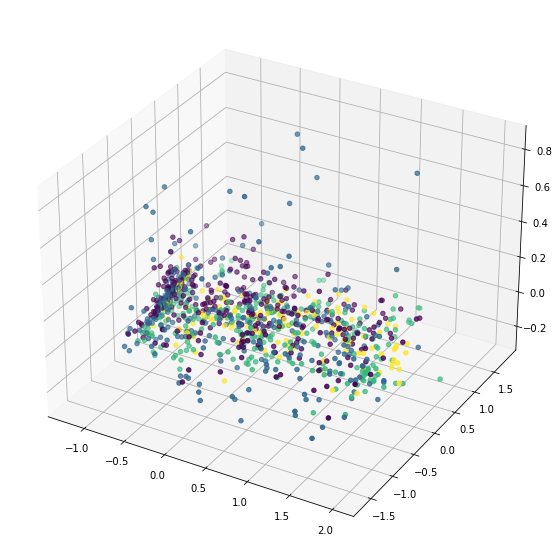

In [152]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 4], c=y)
plt.show()

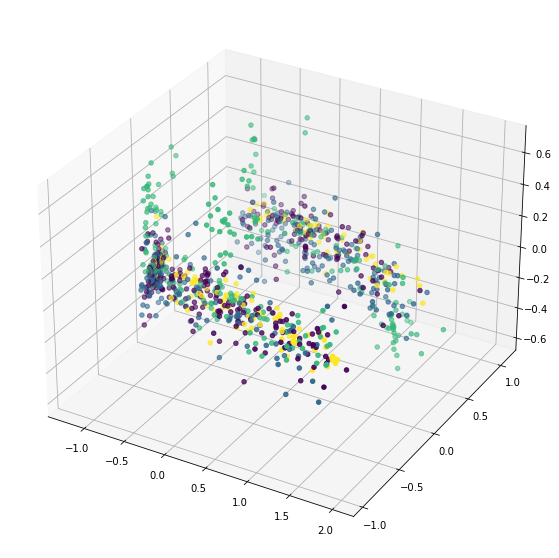

In [154]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 2], X_pca[:, 3], c=y)
plt.show()

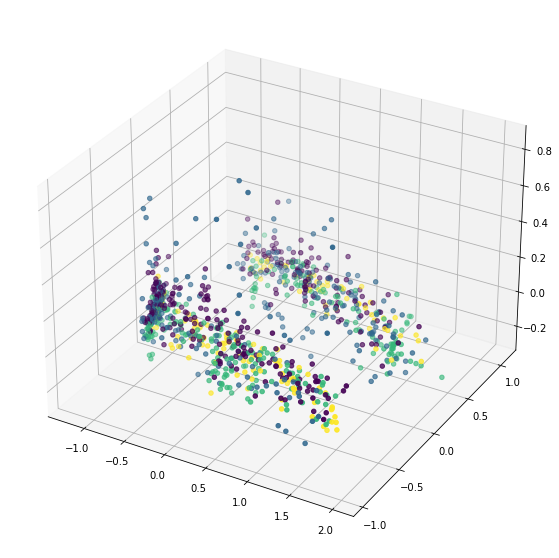

In [155]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 2], X_pca[:, 4], c=y)
plt.show()

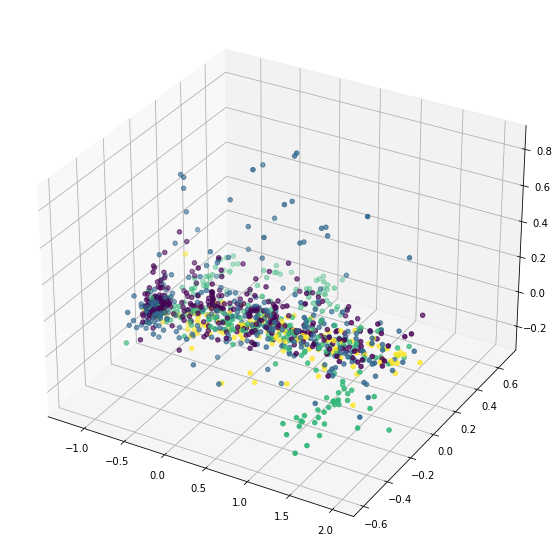

In [156]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 3], X_pca[:, 4], c=y)
plt.show()

In [ ]:
# we want to standardize the features for improving the model

# from sklearn.preprocessing import StandardScaler

# # create object

# scaler = StandardScaler()

# # fit

# scaler.fit(X)

# # transform 

# X_scaled = scaler.transform(as_df)

In [ ]:
# embedding - sentence: use less components
# por o embedding diretamente como features, para depois fazer o PCA
# Supervised Learning: Identify the politician that we talking about.
# Unsupervised Learning: Cluster the tweets, look at the cluster and see what clusters have overwhelm candidates
# do more clusters and see what clusters the politicians share.
# elbow map



# NOT MVP: EMOJI PROCESSING